# Interpolation of Sea Level Anomaly using GPSat
Week 8 contents can be accessed [here](https://drive.google.com/drive/folders/1E0mCn2xJw89O-UD7l9iEpZmlY3XwFWMl?usp=share_link).

## Fetching data

In week 4, we've introduced the method to fetch different types of data from the Google Earth Engine and Copernicus Dataspace. The data we are going to use in this week's content is teh altimetry data. Therefore, we will use Copernicus Dataspace API instead of Google Earth Engine. Let's fetch this data and recall some of the procedures.


In [ ]:
!pip install cartopy
!pip install netCDF4

In [1]:
import requests
import pandas as pd
import subprocess
import os
import time
import shutil
import json
from datetime import date
from joblib import Parallel, delayed
import zipfile
import sys
import glob
import numpy as np

def get_access_token(username, password):
    """
    Obtain an access token to the Copernicus Data Space Ecosystem.
    Necessary for the download of hosted products.
    """
    p =  subprocess.run(f"curl --location --request POST 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' \
            --header 'Content-Type: application/x-www-form-urlencoded' \
            --data-urlencode 'grant_type=password' \
            --data-urlencode 'username={username}' \
            --data-urlencode 'password={password}' \
            --data-urlencode 'client_id=cdse-public'", shell=True,capture_output=True, text=True)
    access_dict = json.loads(p.stdout)
    return access_dict['access_token'], access_dict['refresh_token']

#=============================================================================================================================================================#

def get_new_access_token(refresh_token):
    """
    Obtain a new access token to the Copernicus Data Space Ecosystem using a previously provided refesh token.
    """
    p =  subprocess.run(f"curl --location --request POST 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' \
    --header 'Content-Type: application/x-www-form-urlencoded' \
    --data-urlencode 'grant_type=refresh_token' \
    --data-urlencode 'refresh_token={refresh_token}' \
    --data-urlencode 'client_id=cdse-public'", shell=True,capture_output=True, text=True)
    access_dict = json.loads(p.stdout)
    return access_dict['access_token'], access_dict['refresh_token']

#=============================================================================================================================================================#

def get_S3_products_by_names(names):
    """
    Obtain a pandas dataframe of Sentinel products for a given list of product names.
    """
    all_results = []

    base_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter="

    for name in names:
        query_url = f"{base_url}Name eq '{name}'&$top=1000"
        
        response = requests.get(query_url)
        json_response = response.json()
        
        if 'value' in json_response:
            all_results.extend(json_response['value'])

    results_df = pd.DataFrame.from_dict(all_results)

    if not results_df.empty:
        results_df['Satellite'] = [row['Name'][:3] for i, row in results_df.iterrows()]
        results_df['SensingStart'] = [pd.to_datetime(row['ContentDate']['Start']) for i, row in results_df.iterrows()]
        results_df['SensingEnd'] = [pd.to_datetime(row['ContentDate']['End']) for i, row in results_df.iterrows()]
        results_df = results_df.sort_values(by='SensingStart')
    
    return results_df

def download_single_product(product_id, file_name, access_token, download_dir="downloaded_products"):
    """
    Download a single product from the Copernicus Data Space.

    :param product_id: The unique identifier for the product.
    :param file_name: The name of the file to be downloaded.
    :param access_token: The access token for authorization.
    :param download_dir: The directory where the product will be saved.
    """
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)
    
    # Construct the download URL
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"

    # Set up the session and headers
    headers = {"Authorization": f"Bearer {access_token}"}
    session = requests.Session()
    session.headers.update(headers)

    # Perform the request
    response = session.get(url, headers=headers, stream=True)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Define the path for the output file
        output_file_path = os.path.join(download_dir, file_name + ".zip")

        # Stream the content to a file
        with open(output_file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
        print(f"Downloaded: {output_file_path}")
    else:
        print(f"Failed to download product {product_id}. Status Code: {response.status_code}")

In [11]:
cop_dspace_usrnm = '' # amend with your copernicus dataspace username
cop_dspace_psswrd = ''# amend with your copernicus dataspace password
token, refresh_token = get_access_token(cop_dspace_usrnm, cop_dspace_psswrd)
product_names = [
    "S3A_SR_2_WAT____20230101T185252_20230101T185651_20230101T203101_0239_094_027______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230101T121709_20230101T122349_20230101T135934_0400_094_023______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230102T182657_20230102T183045_20230102T200425_0228_094_041______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230102T115112_20230102T115751_20230102T132929_0399_094_037______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230105T121326_20230105T122007_20230105T134843_0401_094_080______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230105T184910_20230105T185308_20230105T202752_0238_094_084______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230106T182316_20230106T182702_20230106T200253_0226_094_098______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230109T120945_20230109T121625_20230109T135020_0400_094_137______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230103T122643_20230103T123314_20230103T140329_0391_074_294______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230104T183621_20230104T184014_20230104T201141_0233_074_312______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230107T122257_20230107T122931_20230107T135514_0394_074_351______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230107T185833_20230107T190234_20230107T203555_0240_074_355______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230108T183238_20230108T183630_20230108T200807_0232_074_369______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230108T115654_20230108T120333_20230108T133905_0399_074_365______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230111T185450_20230111T185850_20230111T202939_0240_075_027______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230111T121911_20230111T122547_20230111T135219_0396_075_023______MAR_O_NR_005.SEN3"
]

results_df = get_S3_products_by_names(product_names)
print(results_df)




     @odata.mediaContentType                                    Id  \
1   application/octet-stream  df44f31a-61d2-5964-838b-816a54e39e43   
0   application/octet-stream  ccd45b65-52f8-5761-a43a-5909c6b05cc4   
3   application/octet-stream  eef92190-f150-5f99-b61d-6fe53bac377a   
2   application/octet-stream  30e00559-06fb-57f4-9960-544f0f036439   
8   application/octet-stream  68339973-c768-5475-a93f-20b271d53880   
9   application/octet-stream  e7247cfb-ad7c-59ed-80cb-a86f7ca8a5f7   
4   application/octet-stream  f9d13b5d-3ad2-5723-bd0e-2a9f3a685797   
5   application/octet-stream  596577bf-a7eb-5ad3-974a-45e7819244c9   
6   application/octet-stream  e7c0673a-7102-5025-ac1b-d989957274e0   
10  application/octet-stream  d4cc75e3-d55e-5a77-bb26-35efe4f6f918   
11  application/octet-stream  fc0101b5-a4a1-5a1c-9221-ef07a816ed1c   
13  application/octet-stream  45b2e256-9995-5ac3-8070-bfcd00e8e026   
12  application/octet-stream  65b1891a-60ca-5241-b5a8-96aa428b8838   
7   application/octe

Now we download all files altogether.

In [12]:
# Assuming download_single_product is a function that takes product_id, file_name, token, and download_dir as arguments

download_dir = '/Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/'

# Loop through each row in the DataFrame
for index, row in results_df.iterrows():
    product_id = row['Id']
    file_name = row['Name']
    
    # Call the download function for each product
    download_single_product(product_id, file_name, token, download_dir)


Downloaded: /Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/S3A_SR_2_WAT____20230101T121709_20230101T122349_20230101T135934_0400_094_023______MAR_O_NR_005.SEN3.zip
Downloaded: /Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/S3A_SR_2_WAT____20230101T185252_20230101T185651_20230101T203101_0239_094_027______MAR_O_NR_005.SEN3.zip
Downloaded: /Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/S3A_SR_2_WAT____20230102T115112_20230102T115751_20230102T132929_0399_094_037______MAR_O_NR_005.SEN3.zip
Downloaded: /Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/S3A_SR_2_WAT____20230102T182657_20230102T183045_20230102T200425_0228_094_041______MAR_O_NR_005.SEN3.zip
Downloaded: /Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/S3B_SR_2_WAT____20230103T122643_20230103T123314_20230103T140329_0391_074_294______MAR_O_NR_005.SEN3.zip
Downloaded: /Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/S3B_SR_2_WAT____20230104T183621_20230104T184014_20230104T201141_0233_074_312______MAR_O_NR_005.SEN3.zip
Downloaded: /Users/weibinche

By this stage, you should have all the Sentinel-3 files prepared for your analysis. If you need to locate additional files, the [Copernicus Data Space Browser](https://browser.dataspace.copernicus.eu/?zoom=5&lat=50.16282&lng=20.78613&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2Fa91f72b5-f393-4320-bc0f-990129bd9e63&datasetId=S2_L2A_CDAS&demSource3D=%22MAPZEN%22&cloudCoverage=30&dateMode=SINGLE) is an invaluable tool for pinpointing files in specific regions.

### Step 1: Product Selection
Begin by choosing the desired data products. For our purposes, select the SENTINEL-3/SRAL/Level-2 WAT dataset. 
![Data Selection Interface](./image1.png)

You can also define the temporal scope of your search by setting the desired date range.
![Date Range Selection](./image2.png)

### Step 2: Defining the Region of Interest
Use the polygon tool to demarcate your area of interest on the map.
![Region Drawing Tool](./image3.png)

### Step 3: Initiating the Search
With the chosen products, defined time span, and spatial parameters set, the browser will retrieve a list of files that match your criteria.
![Search Results Interface](./image4.png)
![File List Interface](./image5.png)


## SLA Interpolation

Now, the data is all set and we can proceed with the interpolation.

In [29]:
path = '/Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/SLA_GPSat/'
SAR_file='S3A_SR_2_WAT____20230101T121709_20230101T122349_20230101T135934_0400_094_023______MAR_O_NR_005.SEN3'
SAR_data=Dataset(path + SAR_file+'/enhanced_measurement.nc')

In [40]:
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Transformer

# Define the transformation function
def WGS84toEASE2_Vectorized(lon, lat, return_vals="both", lon_0=0, lat_0=90):
    EASE2 = f"+proj=laea +lon_0={lon_0} +lat_0={lat_0} +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = Transformer.from_crs(WGS84, EASE2)
    x, y = transformer.transform(lon, lat)
    if return_vals == 'both':
        return x, y
def EASE2toWGS84(x, y, return_vals="both", lon_0=0, lat_0=90):

    valid_return_vals = ['both', 'lon', 'lat']
    assert return_vals in ['both', 'lon', 'lat'], f"return_val: {return_vals} is not in valid set: {valid_return_vals}"
    EASE2 = f"+proj=laea +lon_0={lon_0} +lat_0={lat_0} +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = Transformer.from_crs(EASE2, WGS84)
    lon, lat = transformer.transform(x, y)
    if return_vals == "both":
        return lon, lat
    elif return_vals == "lon":
        return lon
    elif return_vals == "lat":
        return lat

def get_projection(projection=None):

    # projection
    if projection is None:
        projection = ccrs.NorthPolarStereo()
    elif isinstance(projection, ccrs.Projection):
        pass
    elif isinstance(projection, str):
        if re.search("north", projection, re.IGNORECASE):
            projection = ccrs.NorthPolarStereo()
        elif re.search("south", projection, re.IGNORECASE):
            projection = ccrs.SouthPolarStereo()
        else:
            raise NotImplementedError(f"projection provide as str: {projection}, not implemented")

    return projection
def plot_pcolormesh(ax, lon, lat, plot_data,
                    fig=None,
                    title=None,
                    vmin=None,
                    vmax=None,
                    qvmin=None,
                    qvmax=None,
                    cmap='YlGnBu_r',
                    cbar_label=None,
                    scatter=False,
                    extent=None,
                    ocean_only=False,
                    **scatter_args):

    # ax = axs[j]
    ax.coastlines(resolution='50m', color='white')
    ax.add_feature(cfeat.LAKES, color='white', alpha=.5)
    ax.add_feature(cfeat.LAND, color=(0.8, 0.8, 0.8))
    extent = [-180, 180, 60, 90] if extent is None else extent
    ax.set_extent(extent, ccrs.PlateCarree())  # lon_min,lon_max,lat_min,lat_max

    if title:
        ax.set_title(title)

    if ocean_only:
        if globe_mask is None:
            warnings.warn(f"ocean_only={ocean_only}, however globe_mask is missing, "
                          f"install with pip install global-land-mask")
        else:
            is_in_ocean = globe_mask.is_ocean(lat, lon)
            # copy, just to be safe
            plot_data = copy.copy(plot_data)
            plot_data[~is_in_ocean] = np.nan

    if qvmin is not None:
        if vmin is not None:
            warnings.warn("both qvmin and vmin are supplied, only using qvmin")
        assert (qvmin >= 0) & (qvmin <= 1.0), f"qvmin: {qvmin}, needs to be in [0,1]"
        vmin = np.nanquantile(plot_data, q=qvmin)

    if qvmax is not None:
        if vmax is not None:
            warnings.warn("both qvmax and vmax are supplied, only using qvmax")
        assert (qvmax >= 0) & (qvmax <= 1.0), f"qvmax: {qvmax}, needs to be in [0,1]"
        vmax = np.nanquantile(plot_data, q=qvmax)

    if (vmin is not None) & (vmax is not None):
        assert vmin <= vmax, f"vmin: {vmin} > vmax: {vmax}"

    if not scatter:
        s = ax.pcolormesh(lon, lat, plot_data,
                          cmap=cmap,
                          vmin=vmin, vmax=vmax,
                          transform=ccrs.PlateCarree(),
                          linewidth=0,
                          shading="auto",# to remove DeprecationWarning
                          rasterized=True)
    else:
        non_nan = ~np.isnan(plot_data)
        s = ax.scatter(lon[non_nan],
                       lat[non_nan],
                       c=plot_data[non_nan],
                       cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       transform=ccrs.PlateCarree(),
                       linewidth=0,
                       rasterized=True,
                       **scatter_args)

    if fig is not None:
        cbar = fig.colorbar(s, ax=ax, orientation='horizontal', pad=0.03, fraction=0.03)
        if cbar_label:
            cbar.set_label(cbar_label, fontsize=14)
        cbar.ax.tick_params(labelsize=14)

# Load the dataset
SAR_data = nc.Dataset(path + SAR_file + '/enhanced_measurement.nc')

# Extract spatial and temporal information
lon = SAR_data.variables[lon_var_name][:]
lat = SAR_data.variables[lat_var_name][:]
time = SAR_data.variables[time_var_name][:]
base_time = datetime(2000, 1, 1)
datetimes = np.array([base_time + timedelta(seconds=int(t)) for t in time])
ssha = SAR_data.variables[ssha_var_name][:]

# Convert lon, lat to EASE-2 Grid
x, y = WGS84toEASE2_Vectorized(lon, lat)

# Create a DataFrame
df = pd.DataFrame({
    'lon': lon,
    'lat': lat,
    'datetime': datetimes,
    'obs': ssha
})

# Convert datetime to float days since epoch
df['t'] = (df['datetime'] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1D')

# Apply the coordinate transformation to the DataFrame directly
transformer = Transformer.from_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs", 
                                   "+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs")
df['x'], df['y'] = transformer.transform(df['lon'].values, df['lat'].values)

# Drop rows with NaN in 'obs' column
df.dropna(subset=['obs'], inplace=True)

# Now df has 'x', 'y', 't', and filtered 'obs'
print(df[['x', 'y', 't', 'obs']])


                x             y             t    obs
12  -2.559472e+06  1.241325e+07  19368.513461 -0.025
13  -2.512782e+06  1.242231e+07  19368.513472 -0.014
14  -2.466366e+06  1.243113e+07  19368.513484 -0.057
15  -2.420224e+06  1.243972e+07  19368.513495 -0.056
16  -2.374356e+06  1.244807e+07  19368.513507 -0.062
..            ...           ...           ...    ...
392  4.620373e+06  1.135370e+07  19368.517859  0.040
393  4.626909e+06  1.134917e+07  19368.517870  0.104
394  4.633419e+06  1.134465e+07  19368.517882  0.129
395  4.639904e+06  1.134012e+07  19368.517894  0.174
396  4.646364e+06  1.133560e+07  19368.517905  0.195

[309 rows x 4 columns]


With a collection of 16 files, it's essential to streamline the aforementioned process. Doing so will enable us to amalgamate the individual files into a comprehensive dataframe, forming an extensive dataset for thorough examination.

In [34]:
SEN3_files = [
    "S3A_SR_2_WAT____20230101T185252_20230101T185651_20230101T203101_0239_094_027______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230101T121709_20230101T122349_20230101T135934_0400_094_023______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230102T182657_20230102T183045_20230102T200425_0228_094_041______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230102T115112_20230102T115751_20230102T132929_0399_094_037______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230105T121326_20230105T122007_20230105T134843_0401_094_080______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230105T184910_20230105T185308_20230105T202752_0238_094_084______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230106T182316_20230106T182702_20230106T200253_0226_094_098______MAR_O_NR_005.SEN3",
    "S3A_SR_2_WAT____20230109T120945_20230109T121625_20230109T135020_0400_094_137______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230103T122643_20230103T123314_20230103T140329_0391_074_294______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230104T183621_20230104T184014_20230104T201141_0233_074_312______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230107T122257_20230107T122931_20230107T135514_0394_074_351______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230107T185833_20230107T190234_20230107T203555_0240_074_355______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230108T183238_20230108T183630_20230108T200807_0232_074_369______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230108T115654_20230108T120333_20230108T133905_0399_074_365______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230111T185450_20230111T185850_20230111T202939_0240_075_027______MAR_O_NR_005.SEN3",
    "S3B_SR_2_WAT____20230111T121911_20230111T122547_20230111T135219_0396_075_023______MAR_O_NR_005.SEN3"
]


In [41]:
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Transformer

# Path to your data directory
path = '/Users/weibinchen/Desktop/UCL/PhD_Year_1/Data/SLA_GPSat/'

# Initialise an empty DataFrame to hold all data
all_data_df = pd.DataFrame()

for SAR_file in SEN3_files:
    # Construct the full path to the .nc file
    file_path = path + SAR_file + '/enhanced_measurement.nc'
    
    # Load the dataset
    SAR_data = nc.Dataset(file_path)

    # Extract spatial and temporal information
    lon = SAR_data.variables['lon_01'][:]
    lat = SAR_data.variables['lat_01'][:]
    time = SAR_data.variables['time_01'][:]
    ssha = SAR_data.variables['ssha_01_ku'][:]  # Assuming ssha_01_ku exists in all files

    # Convert time to datetime objects
    base_time = datetime(2000, 1, 1)
    datetimes = np.array([base_time + timedelta(seconds=int(t)) for t in time])

    # Convert lon, lat to EASE-2 Grid
    transformer = Transformer.from_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs", 
                                       "+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs")
    x, y = transformer.transform(lon, lat)

    # Create a DataFrame for this file
    df = pd.DataFrame({
        'x': x,
        'y': y,
        't': (pd.to_datetime(datetimes) - pd.Timestamp("1970-01-01")) / pd.Timedelta('1D'),
        'obs': ssha
    })

    # Drop rows where 'obs' is NaN
    df.dropna(subset=['obs'], inplace=True)

    # Append to the all_data_df DataFrame
    all_data_df = pd.concat([all_data_df, df], ignore_index=True)

# Now all_data_df contains concatenated data from all files
print(all_data_df)


                 x             y             t    obs
0    -5.559457e+06  1.116669e+07  19358.786713  0.024
1    -5.548324e+06  1.117362e+07  19358.786725  0.004
2    -5.537133e+06  1.118055e+07  19358.786736 -0.011
3    -5.525884e+06  1.118750e+07  19358.786748 -0.011
4    -5.514576e+06  1.119445e+07  19358.786759  0.004
...            ...           ...           ...    ...
3104  4.620373e+06  1.135370e+07  19368.517859  0.040
3105  4.626909e+06  1.134917e+07  19368.517870  0.104
3106  4.633419e+06  1.134465e+07  19368.517882  0.129
3107  4.639904e+06  1.134012e+07  19368.517894  0.174
3108  4.646364e+06  1.133560e+07  19368.517905  0.195

[3109 rows x 4 columns]


In [ ]:
import pandas as pd

savepath = ''

# Assuming all_data_df is your DataFrame
all_data_df.to_csv(savepath+'all_data.csv', index=False)

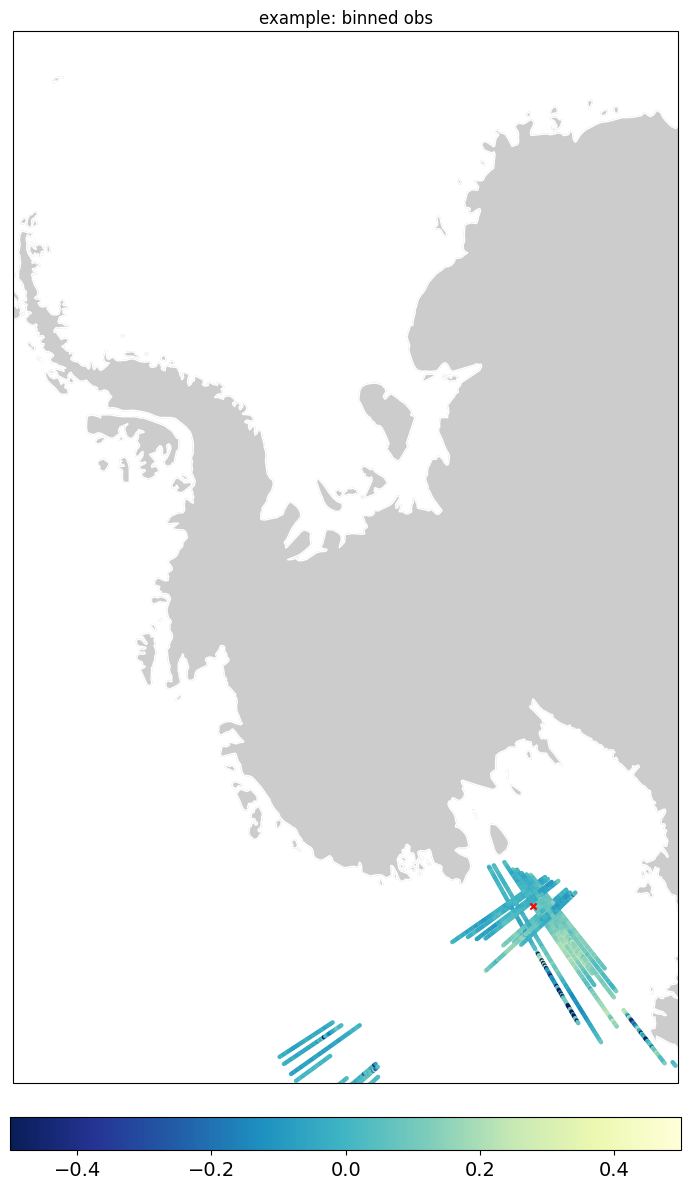

In [54]:
import re
import cartopy.feature as cfeat
import cartopy.crs as ccrs

all_data_df['lon'], all_data_df['lat'] = EASE2toWGS84(all_data_df['x'], all_data_df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('south'))

plot_pcolormesh(ax=ax,
                lon=all_data_df['lon'],
                lat=all_data_df['lat'],
                plot_data=all_data_df['obs'],
                title="example: binned obs",
                scatter=True,
                s=10,
                fig=fig,
                # extent=[-180, 180, -90, -60],
                extent=[10, -150, -80, -67],
                vmin=-0.5,vmax=0.5)

plt.scatter(x=-171.5, y=-77, s=20, marker='x', color='red', transform=ccrs.PlateCarree())
plt.tight_layout()
plt.show()

Now we proceed with GPSat, with the same process we went through in week 7.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# TODO: allow for mounting of gdrive
# TODO: allow for checking out a branch

if IN_COLAB:

    import os
    import re

    # change to working directory
    work_dir = "/content"

    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)

    # clone repository
    !git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)

In [ ]:
if IN_COLAB:
    !pip install -r requirements.txt

In [ ]:
if IN_COLAB:
    !pip install -e .

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data
from GPSat.config_dataclasses import DataConfig, ModelConfig, PredictionLocsConfig, ExpertLocsConfig
from GPSat.postprocessing import glue_local_predictions_2d


In [ ]:
import pandas as pd

savepath = ''
# Load DataFrame from CSV file
df = pd.read_csv(savepath+'all_data.csv')

df['z']=df['obs']

In [ ]:
# - spaced every 10km for some x,y range
xy_grid = grid_2d_flatten(x_range=[-2000000.0, -1800000.0],
                          y_range=[12400000.0, 12600000.0],
                          step_size=10_000)



# store in dataframe
eloc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# add a time coordinate
eloc['t'] = np.floor(df['t'].mean())

print("Local expert locations:")
eloc.head()

In [ ]:
import re
import cartopy.feature as cfeat
import cartopy.crs as ccrs
# plot expert locations
eloc['lon'], eloc['lat'] = EASE2toWGS84_New(eloc['x'], eloc['y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('south'))

plot_pcolormesh(ax=ax,
                lon=eloc['lon'],
                lat=eloc['lat'],
                plot_data=eloc['t'],
                title="expert locations",
                scatter=True,
                s=20,
                extent=[-180, 180, -90, -60])

plt.scatter(x=-171.5, y=-77, s=20, marker='x', color='red', transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

In [ ]:
# - spaced every 5km

xy_grid = grid_2d_flatten(x_range=[-2000000.0, -1800000.0],
                          y_range=[12400000.0, 12600000.0],
                          step_size=5_000)

# store in dataframe
# NOTE: the missing 't' coordinate will be determine by the expert location
# - alternatively the prediction location can be specified
ploc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# Add lon-lat measurements
ploc['lon'], ploc['lat'] = EASE2toWGS84_New(ploc['x'], ploc['y'])

print("Prediction locations:")
ploc

In [ ]:
# Set training and inference radius
training_radius = 300_000   # 300km
inference_radius = 200_000  # 200km

# Local expert locations config
local_expert = ExpertLocsConfig(source = eloc)

# Model config
model = ModelConfig(oi_model = "GPflowGPRModel", # Use GPflow GPR model
                    init_params = {
                        # normalise xy coordinates by 50km
                        "coords_scale": [50_000, 50_000, 1]
                        },
                    constraints = {
                        # set bounds on the lengthscale hyperparameters
                        "lengthscales": {
                            "low": [1e-08, 1e-08, 1e-08],
                            "high": [600_000, 600_000, 9]
                        }
                        }
                    )

# Data config
data = DataConfig(data_source = df,
                  obs_col = "z",
                  coords_col = ["x", "y", "t"],
                  local_select = [
                    # Select data within 300km and ± 4 days of the expert location
                    {"col": "t", "comp": "<=", "val": 4},
                    {"col": "t", "comp": ">=", "val": -4},
                    {"col": ["x", "y"], "comp": "<", "val": training_radius}
                  ]
                )

# Prediction locs config
pred_loc = PredictionLocsConfig(method = "from_dataframe",
                                df = ploc,
                                max_dist = inference_radius)


In [ ]:
locexp = LocalExpertOI(expert_loc_config = local_expert,
                       data_config = data,
                       model_config = model,
                       pred_loc_config = pred_loc)


In [ ]:
# path to store results
store_path = get_parent_path("results", "inline_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=store_path)

In [ ]:
# extract, store in dict
dfs, _ = get_results_from_h5file(store_path)

print(f"tables in results file: {list(dfs.keys())}")


In [ ]:
preds_data = dfs["preds"]
preds_data.head()

# multiple local experts may make predictions at the same prediction location (pred_loc).
# - for each prediction at a given location, take we weighted combination
# - weights being a function of the distance to each local expert that made a prediction at a given location.

plt_data = glue_local_predictions_2d(preds_df=preds_data,
                                     pred_loc_cols=["pred_loc_x", "pred_loc_y"],
                                     xprt_loc_cols=["x", "y"],
                                     vars_to_glue=["f*", "f*_var"],
                                     inference_radius=inference_radius)

plt_data.head()


In [ ]:
# plot prediction locations
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('south'))

plot_pcolormesh(ax=ax,
                lon=ploc['lon'],
                lat=ploc['lat'],
                plot_data=np.full(len(ploc), 1.0), #np.arange(len(ploc)),
                title="prediction locations",
                scatter=True,
                s=0.1,
                extent=[10, -150, -80, -67])

plt.tight_layout()
plt.show()


In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('south'))

plot_pcolormesh(ax=ax,
                lon=ploc['lon'],
                lat=ploc['lat'],
                plot_data=plt_data['f*'], #np.arange(len(ploc)),
                title="prediction locations",
                scatter=True,
                s=0.1,
                extent=[10, -150, -80, -67])

plt.tight_layout()
plt.show()